<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

inputs = tf.keras.Input(shape=(28, 28), dtype=tf.float32)
h = tf.keras.layers.Rescaling(scale=1./255)(inputs)
outputs = tf.keras.layers.Reshape(target_shape=(784,))(h)
preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=64)
    ds = ds.map(map_func=lambda x, y: (preprocessing_model(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')
import time

inputs = tf.keras.Input(shape=(784,))
h = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs)
h = tf.keras.layers.Dropout(rate=0.2)(h)
outputs = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)(h)
training_model = tf.keras.Model(inputs=inputs, outputs=outputs)
training_model.summary()

training_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)

@tf.function
def train_step(model, x, y):
    logs = {}
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = model.compute_loss(y=y, y_pred=y_pred)

    trainable_vars = model.trainable_variables
    grads = tape.gradient(target=loss,
        sources=trainable_vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(
        grads, trainable_vars))

    for metric in model.metrics:
        if metric.name=="loss":
            metric.update_state(values=loss)
        else:
            metric.update_state(y_true=y, y_pred=y_pred)

    metrics = [m.result() for m in model.metrics]
    logs = {f"train_{k}": v for k, v in metrics[1].items()}
    logs["train_loss"] = metrics[0]
    for metric in model.metrics:
        metric.reset_state()

    return logs

@tf.function
def test_step(model, x, y):
    y_pred = model(inputs=x, training=False)
    loss = model.compute_loss(y=y, y_pred=y_pred)

    for metric in model.metrics:
        if metric.name=="loss":
            metric.update_state(values=loss)
        else:
            metric.update_state(y_true=y, y_pred=y_pred)

    metrics = [m.result() for m in model.metrics]
    logs = {f"test_{k}": v for k, v in metrics[1].items()}
    logs["test_loss"] = metrics[0]
    for metric in model.metrics:
        metric.reset_state()

    return logs

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=training_model,
    callbacks=[reduce_lr], add_history=True)

num_epochs = 10
start_time = time.time()
history = {
    "train_loss": [], "test_loss": [],
    "train_accuracy": [], "test_accuracy": []
}
logs = {}
callbacks.on_train_begin(logs=logs)
for epoch in range(num_epochs):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for x, y in ds_train:
        logs = train_step(model=training_model, x=x, y=y)
    history["train_loss"].append(logs["train_loss"].numpy())
    history["train_accuracy"].append(logs["train_accuracy"].numpy())

    for x, y in ds_test:
        logs = test_step(model=training_model, x=x, y=y)
    history["test_loss"].append(logs["test_loss"].numpy())
    history["test_accuracy"].append(logs["test_accuracy"].numpy())

    callbacks.on_epoch_end(epoch=epoch, logs=logs)

callbacks.on_train_end(logs=logs)
print("Training duration: %.2fs"%(time.time() - start_time))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

Training duration: 36.65s


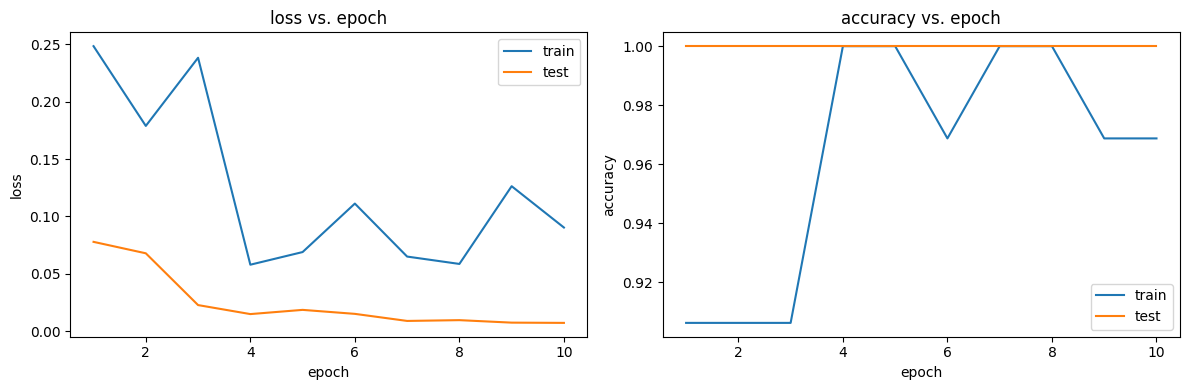

In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

df_history = pd.DataFrame(history)
df_history['epoch'] = np.arange(num_epochs) + 1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for ax, m in zip(axes, ["loss", "accuracy"]):
    g = sns.lineplot(ax=ax, data=df_history, label='train', x='epoch', y=f'train_{m}')
    g = sns.lineplot(ax=ax, data=df_history, label='test', x='epoch', y=f'test_{m}')
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

In [5]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')

inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)
inference_model.save('models/model.keras')

idx = 24
x_pred = np.reshape(a=x_test[idx], newshape=(1, 28, 28))
inference_model = tf.keras.models.load_model('models/model.keras')
y_pred = inference_model(x_pred)
print('y_true:', y_test[idx], 'y_pred:', np.argmax(y_pred))

y_true: 4 y_pred: 4
